In [1]:
import pandas as pd
import datetime as dt
online=pd.read_csv("C://Users//POPO//Desktop//online.csv")
online.head()

,Unnamed: 0,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,70701,542096,10002,INFLATABLE POLITICAL GLOBE,2,2011/1/25 12:52,0.85,17236,United Kingdom
1,20617,538069,10002,INFLATABLE POLITICAL GLOBE,8,2010/12/9 14:08,0.85,16795,United Kingdom
2,52333,540732,10002,INFLATABLE POLITICAL GLOBE,12,2011/1/11 10:19,0.85,16122,United Kingdom
3,127450,547223,10002,INFLATABLE POLITICAL GLOBE,5,2011/3/21 15:10,0.85,12867,United Kingdom
4,22380,538167,10002,INFLATABLE POLITICAL GLOBE,12,2010/12/9 18:58,0.85,14713,United Kingdom


In [2]:
online.drop("Unnamed: 0",axis=1,inplace=True)
print(online.shape)

(70803, 8)


In [3]:
print("總共有幾位顧客: ",len(pd.unique(online["CustomerID"])))
print("總共有幾筆資料: ",online.shape[0])
print("總共有幾樣產品: ",len(pd.unique(online["StockCode"])))

總共有幾位顧客:  3699
總共有幾筆資料:  70803
總共有幾樣產品:  3222


# 用產品內容描述來做產品分群

In [4]:
from __future__ import print_function
import pandas as pd
from nltk.stem.snowball import SnowballStemmer
import time

from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

import random
# This can be improved a lot
def preprocessor(data):
    return " ".join([SnowballStemmer("english").stem(word) for word in data.split()])

In [5]:
t0 = time.time()
vectorizer = TfidfVectorizer(preprocessor=preprocessor,
                                  max_df=0.8,
                                  min_df=0.06,
                                  stop_words='english')

tfidf = vectorizer.fit_transform(online["Description"])
print("Tf-idf in %fs" % (time.time() - t0))

C:\Users\POPO\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:301: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'afterward', 'alon', 'alreadi', 'alway', 'ani', 'anoth', 'anyon', 'anyth', 'anywher', 'becam', 'becaus', 'becom', 'befor', 'besid', 'cri', 'describ', 'dure', 'els', 'elsewher', 'empti', 'everi', 'everyon', 'everyth', 'everywher', 'fifti', 'forti', 'henc', 'hereaft', 'herebi', 'howev', 'hundr', 'inde', 'mani', 'meanwhil', 'moreov', 'nobodi', 'noon', 'noth', 'nowher', 'onc', 'onli', 'otherwis', 'ourselv', 'perhap', 'pleas', 'sever', 'sinc', 'sincer', 'sixti', 'someon', 'someth', 'sometim', 'somewher', 'themselv', 'thenc', 'thereaft', 'therebi', 'therefor', 'togeth', 'twelv', 'twenti', 'veri', 'whatev', 'whenc', 'whenev', 'wherea', 'whereaft', 'wherebi', 'wherev', 'whi', 'yourselv'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


Tf-idf in 4.755314s


In [6]:
from sklearn.decomposition import TruncatedSVD
n_components = 5
tsvd = TruncatedSVD(n_components=n_components)
tsvd_result = tsvd.fit_transform(tfidf)
explained_variance = tsvd.explained_variance_ratio_.sum()
# The svd explains only a tiny portion of the variance
print("Explained variance %f" % (explained_variance))

Explained variance 0.924519


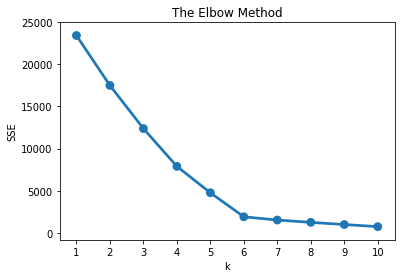

In [7]:
from sklearn.cluster import KMeans
import seaborn as sns
from matplotlib import pyplot as plt
sse = {}
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=1)
    kmeans.fit(tsvd_result)
    sse[k] = kmeans.inertia_ # sum of squared distances to closest cluster cente
# Plot SSE for each *k*
plt.title('The Elbow Method')
plt.xlabel('k'); plt.ylabel('SSE')
sns.pointplot(x=list(sse.keys()), y=list(sse.values()))
plt.show()

In [8]:
kmeans = KMeans(n_clusters=6, random_state=1)
kmeans.fit(tsvd_result)
cluster_labels = kmeans.labels_
online = online.assign(Clusterproduct = cluster_labels)

In [9]:
online.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Clusterproduct
0,542096,10002,INFLATABLE POLITICAL GLOBE,2,2011/1/25 12:52,0.85,17236,United Kingdom,1
1,538069,10002,INFLATABLE POLITICAL GLOBE,8,2010/12/9 14:08,0.85,16795,United Kingdom,1
2,540732,10002,INFLATABLE POLITICAL GLOBE,12,2011/1/11 10:19,0.85,16122,United Kingdom,1
3,547223,10002,INFLATABLE POLITICAL GLOBE,5,2011/3/21 15:10,0.85,12867,United Kingdom,1
4,538167,10002,INFLATABLE POLITICAL GLOBE,12,2010/12/9 18:58,0.85,14713,United Kingdom,1


In [10]:
online["Clusterproduct"].value_counts()

1    43110
0     6615
2     6355
4     5587
5     4638
3     4498
Name: Clusterproduct, dtype: int64

# 用Stock Code來做產品分群

In [11]:
online["product type"]=online["StockCode"].apply(lambda x:x[0])
online["product type"].value_counts()

2    58168
8     8209
4     1492
7      996
1      948
3      622
9      271
5       82
6       15
Name: product type, dtype: int64

# 用產品內容的描述來了解各類產品的相關程度

In [12]:
online["w2vector"]=list(tsvd_result)
from sklearn.decomposition import TruncatedSVD
import numpy as np
def transform(x):
    if len(x)<5:
        x.append(0)
    return x
online["w2vector"]=online["w2vector"].apply(transform)
tsvd = TruncatedSVD(n_components=2)
tsvd = tsvd.fit_transform(list(online["w2vector"]))
tsvddata=pd.DataFrame(tsvd)
tsvddata.index=online["StockCode"]
tsvddata["category"]=list(online["Clusterproduct"])
tsvddata.head()

,0,1,category
StockCode,,,
10002,-1.185150e-13,-1.950603e-13,1
10002,-9.552320e-14,-4.916448e-13,1
10002,-1.147739e-13,-3.166035e-13,1
10002,-7.967800e-15,5.819266e-14,1
10002,1.697728e-15,1.474859e-14,1


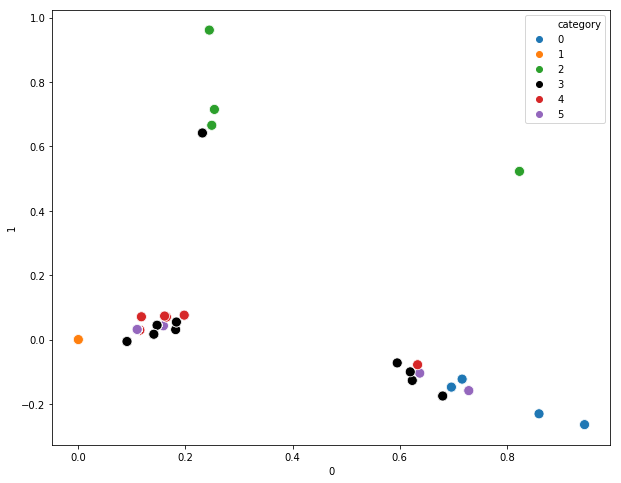

In [13]:
tsvddata = tsvddata.reset_index().drop_duplicates(subset='StockCode', keep='last').set_index('StockCode')
plt.figure(figsize=(10,8))
sns.scatterplot(x=0, y=1, s=100,data=tsvddata,hue="category",palette=["C0", "C1","C2", "k","C3","C4"])

In [14]:
online["TotalSum"]=online["UnitPrice"]*online["Quantity"]

In [15]:
def get_month(x): return dt.datetime(x.year,x.month,1)
online['InvoiceDay'] = pd.to_datetime(online['InvoiceDate']).apply(get_month)
online=online.dropna()
online["CustomerID"]=online["CustomerID"].astype("category")
online.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Clusterproduct,product type,w2vector,TotalSum,InvoiceDay
0,542096,10002,INFLATABLE POLITICAL GLOBE,2,2011/1/25 12:52,0.85,17236,United Kingdom,1,1,"[-1.145854224744913e-13, -2.264510723847783e-1...",1.70,2011-01-01
1,538069,10002,INFLATABLE POLITICAL GLOBE,8,2010/12/9 14:08,0.85,16795,United Kingdom,1,1,"[-6.391408708174464e-14, -2.312623713412137e-1...",6.80,2010-12-01
2,540732,10002,INFLATABLE POLITICAL GLOBE,12,2011/1/11 10:19,0.85,16122,United Kingdom,1,1,"[-1.134604018279929e-13, -3.8655304524018884e-...",10.20,2011-01-01
3,547223,10002,INFLATABLE POLITICAL GLOBE,5,2011/3/21 15:10,0.85,12867,United Kingdom,1,1,"[-2.253236992131428e-15, -4.824606218132795e-1...",4.25,2011-03-01
4,538167,10002,INFLATABLE POLITICAL GLOBE,12,2010/12/9 18:58,0.85,14713,United Kingdom,1,1,"[1.7605628097709381e-15, 1.4050372894155473e-1...",10.20,2010-12-01


In [21]:
datanov=online[online["InvoiceDay"]=="2011-11-01"].groupby("product type")["InvoiceNo"].count()

In [22]:
#感恩節時的資料
thanksgiving=online[online["InvoiceDay"]=="2011-11-01"]

In [23]:
datanov=pd.DataFrame(datanov)
import matplotlib.pyplot as plt
%matplotlib inline
datanov

,InvoiceNo
product type,
1,118
2,9989
3,113
4,144
5,21
6,2
7,156
8,1058
9,34


(array([0, 1, 2, 3, 4, 5, 6, 7, 8]), <a list of 9 Text xticklabel objects>)

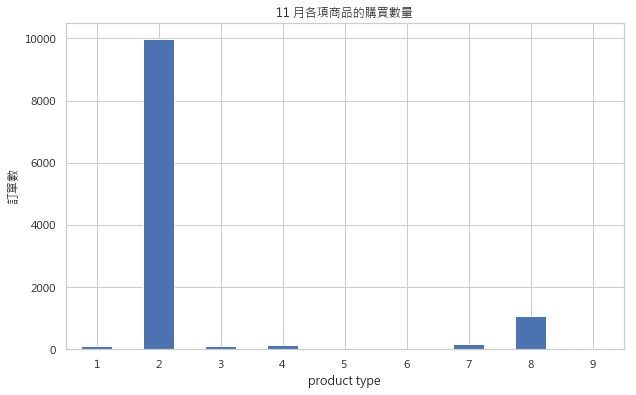

In [24]:
import seaborn as sns
from matplotlib.font_manager import FontProperties
import seaborn as sns
sns.set(font=['sans-serif'])
sns.set_style("whitegrid",{"font.sans-serif":['Microsoft JhengHei']})
plt.figure(figsize=(10,6))
datanov['InvoiceNo'].plot(kind='bar')
plt.title("11 月各項商品的購買數量")
plt.ylabel("訂單數")
plt.xticks(rotation=0)

Text(0.5,1,'11月各項商品的購買總額')

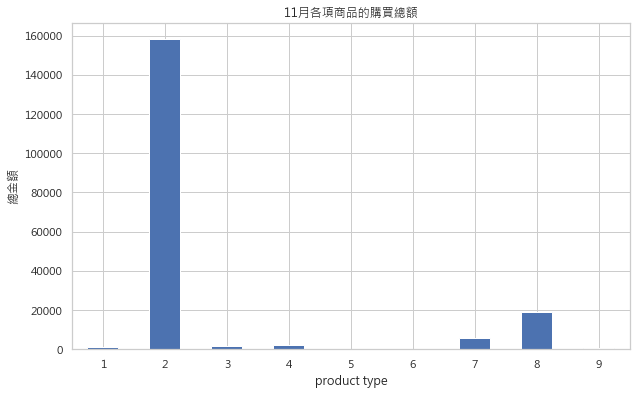

In [25]:
datanov=online[online["InvoiceDay"]=="2011-11-01"].groupby("product type")["TotalSum"].sum()
datanov=pd.DataFrame(datanov)
plt.figure(figsize=(10,6))
datanov['TotalSum'].plot(kind='bar')
plt.title("11 月各項商品的購買總額")
plt.ylabel("總金額")
plt.xticks(rotation=0)
plt.title("11月各項商品的購買總額")

Text(0.5,1,'全年各項商品的購買總額')

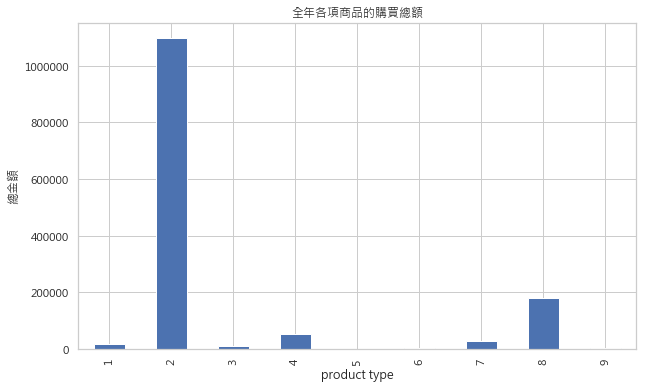

In [26]:
allyear=online.groupby("product type")["TotalSum"].sum()
allyear=pd.DataFrame(allyear)
plt.figure(figsize=(10,6))
allyear['TotalSum'].plot(kind='bar')
plt.xticks(rotation=90)
plt.ylabel("總金額")
plt.title("全年各項商品的購買總額")

Text(0.5,0,'日期')

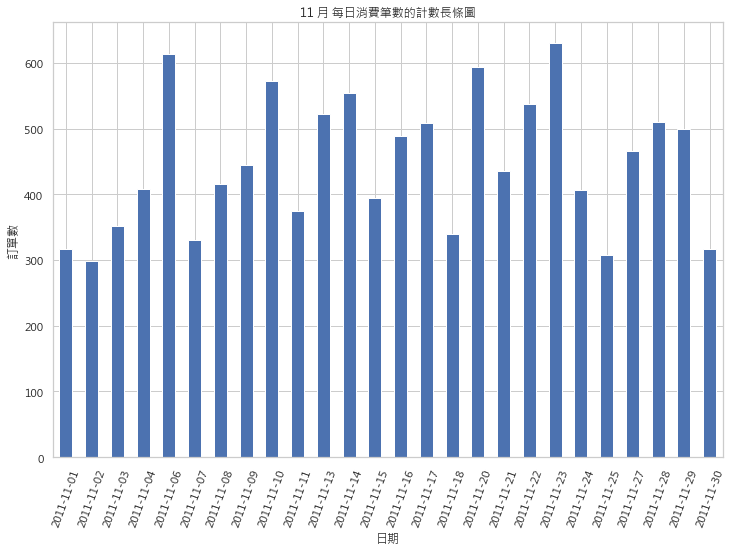

In [27]:
def get_day(x): return dt.datetime(x.year,x.month,x.day)
online["day"]=pd.to_datetime(online["InvoiceDate"]).apply(get_day)
a1=online[online["InvoiceDay"]=="2011-11-01"].groupby("day")["InvoiceNo"].count()
a1=pd.DataFrame(a1)
a1=a1.reset_index()
a1["day"]=a1["day"].apply(lambda x:str(x)[:10])
a1=a1.set_index("day")
plt.figure(figsize=(12, 8))

a1['InvoiceNo'].plot(kind='bar')
plt.xticks(rotation=70)
plt.title("11 月 每日消費筆數的計數長條圖")
plt.ylabel("訂單數")
plt.xlabel("日期")

In [28]:
online["hour"]=pd.to_datetime(online['InvoiceDate']).apply(lambda x:x.hour)
online.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Clusterproduct,product type,w2vector,TotalSum,InvoiceDay,day,hour
0,542096,10002,INFLATABLE POLITICAL GLOBE,2,2011/1/25 12:52,0.85,17236,United Kingdom,1,1,"[-1.145854224744913e-13, -2.264510723847783e-1...",1.70,2011-01-01,2011-01-25,12
1,538069,10002,INFLATABLE POLITICAL GLOBE,8,2010/12/9 14:08,0.85,16795,United Kingdom,1,1,"[-6.391408708174464e-14, -2.312623713412137e-1...",6.80,2010-12-01,2010-12-09,14
2,540732,10002,INFLATABLE POLITICAL GLOBE,12,2011/1/11 10:19,0.85,16122,United Kingdom,1,1,"[-1.134604018279929e-13, -3.8655304524018884e-...",10.20,2011-01-01,2011-01-11,10
3,547223,10002,INFLATABLE POLITICAL GLOBE,5,2011/3/21 15:10,0.85,12867,United Kingdom,1,1,"[-2.253236992131428e-15, -4.824606218132795e-1...",4.25,2011-03-01,2011-03-21,15
4,538167,10002,INFLATABLE POLITICAL GLOBE,12,2010/12/9 18:58,0.85,14713,United Kingdom,1,1,"[1.7605628097709381e-15, 1.4050372894155473e-1...",10.20,2010-12-01,2010-12-09,18


Text(0,0.5,'訂單數')

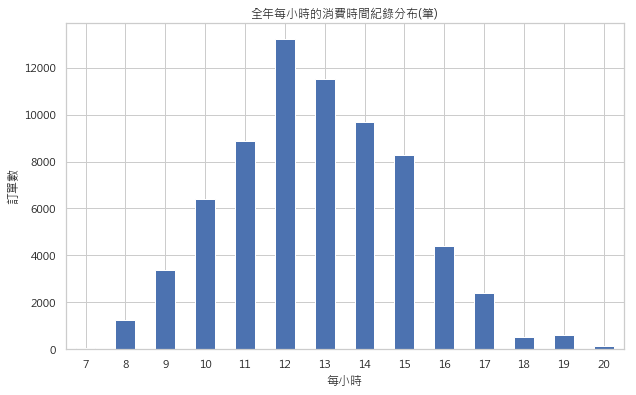

In [29]:
a2=online.groupby("hour")["InvoiceNo"].count()
a2=pd.DataFrame(a2)
plt.figure(figsize=(10,6))

a2['InvoiceNo'].plot(kind='bar')
plt.xticks(rotation=0)
plt.title("全年每小時的消費時間紀錄分布(筆)")
plt.xlabel("每小時")
plt.ylabel("訂單數")

# 顧客保留率

In [30]:
grouping = online.groupby('CustomerID')['InvoiceDay'].transform('min') #找出顧客最早有購買紀錄的時間
online['CohortMonth'] = grouping

In [31]:
def get_date_int(df, column):
    df[column]=pd.to_datetime(df[column])
    year = df[column].dt.year
    month = df[column].dt.month
    day = df[column].dt.day
    return year, month, day

In [32]:
invoice_year, invoice_month, _ = get_date_int(online,'InvoiceDay')
cohort_year, cohort_month, _ = get_date_int(online,'CohortMonth')
years_diff = invoice_year - cohort_year
months_diff = invoice_month - cohort_month
online['CohortIndex'] = years_diff * 12 + months_diff + 1  #觀察多久
online.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Clusterproduct,product type,w2vector,TotalSum,InvoiceDay,day,hour,CohortMonth,CohortIndex
0,542096,10002,INFLATABLE POLITICAL GLOBE,2,2011/1/25 12:52,0.85,17236,United Kingdom,1,1,"[-1.145854224744913e-13, -2.264510723847783e-1...",1.70,2011-01-01,2011-01-25,12,2010-12-01,2
1,538069,10002,INFLATABLE POLITICAL GLOBE,8,2010/12/9 14:08,0.85,16795,United Kingdom,1,1,"[-6.391408708174464e-14, -2.312623713412137e-1...",6.80,2010-12-01,2010-12-09,14,2010-12-01,1
2,540732,10002,INFLATABLE POLITICAL GLOBE,12,2011/1/11 10:19,0.85,16122,United Kingdom,1,1,"[-1.134604018279929e-13, -3.8655304524018884e-...",10.20,2011-01-01,2011-01-11,10,2010-12-01,2
3,547223,10002,INFLATABLE POLITICAL GLOBE,5,2011/3/21 15:10,0.85,12867,United Kingdom,1,1,"[-2.253236992131428e-15, -4.824606218132795e-1...",4.25,2011-03-01,2011-03-21,15,2010-12-01,4
4,538167,10002,INFLATABLE POLITICAL GLOBE,12,2010/12/9 18:58,0.85,14713,United Kingdom,1,1,"[1.7605628097709381e-15, 1.4050372894155473e-1...",10.20,2010-12-01,2010-12-09,18,2010-12-01,1


In [33]:
online["CohortMonth"]=online["CohortMonth"].apply(lambda x:str(x)[:10])
grouping = online.groupby(['CohortMonth','CohortIndex'])
cohort_data = grouping['CustomerID'].apply(pd.Series.nunique)
cohort_data = cohort_data.reset_index()
cohort_counts = cohort_data.pivot(index='CohortMonth',columns='CohortIndex',values='CustomerID')
cohort_counts

CohortIndex,1,2,3,4,5,6,7,8,9,10,11,12,13
CohortMonth,,,,,,,,,,,,,
2010-12-01,716.0,246.0,221.0,251.0,245.0,285.0,249.0,235.0,240.0,265.0,253.0,348.0,172.0
2011-01-01,332.0,69.0,82.0,81.0,110.0,90.0,82.0,86.0,104.0,102.0,124.0,45.0,NaN
2011-02-01,316.0,57.0,57.0,83.0,85.0,74.0,80.0,83.0,86.0,95.0,28.0,NaN,NaN
2011-03-01,388.0,63.0,100.0,76.0,83.0,67.0,98.0,85.0,107.0,38.0,NaN,NaN,NaN
2011-04-01,255.0,49.0,52.0,49.0,47.0,52.0,56.0,59.0,17.0,NaN,NaN,NaN,NaN
2011-05-01,249.0,40.0,43.0,36.0,52.0,58.0,61.0,22.0,NaN,NaN,NaN,NaN,NaN
2011-06-01,207.0,33.0,26.0,41.0,49.0,62.0,19.0,NaN,NaN,NaN,NaN,NaN,NaN
2011-07-01,172.0,28.0,30.0,38.0,43.0,17.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-08-01,139.0,29.0,28.0,35.0,14.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [34]:
#客戶保持率變化
cohort_sizes = cohort_counts.iloc[:,0]
retention = cohort_counts.divide(cohort_sizes, axis=0)
retention.round(3) * 100

CohortIndex,1,2,3,4,5,6,7,8,9,10,11,12,13
CohortMonth,,,,,,,,,,,,,
2010-12-01,100.0,34.4,30.9,35.1,34.2,39.8,34.8,32.8,33.5,37.0,35.3,48.6,24.0
2011-01-01,100.0,20.8,24.7,24.4,33.1,27.1,24.7,25.9,31.3,30.7,37.3,13.6,NaN
2011-02-01,100.0,18.0,18.0,26.3,26.9,23.4,25.3,26.3,27.2,30.1,8.9,NaN,NaN
2011-03-01,100.0,16.2,25.8,19.6,21.4,17.3,25.3,21.9,27.6,9.8,NaN,NaN,NaN
2011-04-01,100.0,19.2,20.4,19.2,18.4,20.4,22.0,23.1,6.7,NaN,NaN,NaN,NaN
2011-05-01,100.0,16.1,17.3,14.5,20.9,23.3,24.5,8.8,NaN,NaN,NaN,NaN,NaN
2011-06-01,100.0,15.9,12.6,19.8,23.7,30.0,9.2,NaN,NaN,NaN,NaN,NaN,NaN
2011-07-01,100.0,16.3,17.4,22.1,25.0,9.9,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-08-01,100.0,20.9,20.1,25.2,10.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


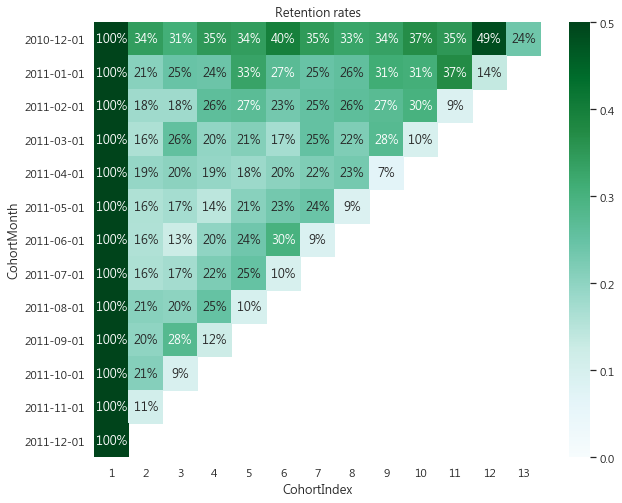

In [35]:
import seaborn as sns 
import matplotlib.pyplot as plt 
plt.figure(figsize=(10, 8)) 
plt.title('Retention rates')
#小數點後零位，並且以百分比行式輸出
#annot : 如果為True，則將數值填入每個方格中
#vmax,vmin:圖例中最大值和最小值的顯示值
#%matplotlib inline
sns.heatmap(data = retention,annot = True,fmt = '.0%', vmin = 0.0, vmax = 0.5, cmap = 'BuGn') 
plt.show()

# RFM

In [36]:
#RFM
#R（Recency）「新客」（近期有消費的人）、 F（Frequency） 「常客」（常常來消費的人）、與 M（Monetary）「貴客」（消費金額大的人）
#最近一次消費（Recency）：指消費者至今再次購買與上次購買產品的時間差
#消費金額（Monetary）：指消費者在一定期間內購買該產品的總金額
#消費頻率（Frequency）：指消費者在一定期間內購買該產品的次數

#Recency - days since last customer transaction
#Frequency - number of transactions in the last 12 months
#Monetary Value - total spend in the last 12 months

In [37]:
from datetime import datetime
snapshot_date = pd.to_datetime(online.InvoiceDate).max() + dt.timedelta(days=1)
snapshot_date=datetime.strptime(str(snapshot_date), "%Y-%m-%d %H:%M:%S")
snapshot_date=pd.to_datetime(snapshot_date)
snapshot_date

Timestamp('2011-12-10 12:49:00')

In [38]:
datamart = online.groupby(['CustomerID']).agg({
'InvoiceDate': lambda x: (snapshot_date-pd.to_datetime(x).max()).days,'InvoiceNo': 'count',
'TotalSum': 'sum'})
# Rename columns for easier interpretation
datamart.rename(columns = {'InvoiceDate': 'Recency'
,'InvoiceNo': 'Frequency',
'TotalSum': 'MonetaryValue'}, inplace=True)
datamart.head()

,Recency,Frequency,MonetaryValue
CustomerID,,,
12747,2,27,992.82
12748,1,964,6668.28
12749,4,37,813.45
12820,3,17,268.02
12822,71,9,146.15


In [39]:
f_labels = range(1,5)
m_labels = range(1,5)
f_quartiles = pd.qcut(datamart['Frequency'], 4, labels = f_labels)
m_quartiles = pd.qcut(datamart['MonetaryValue'], 4, labels = m_labels)
datamart = datamart.assign(F = f_quartiles.values)
datamart = datamart.assign(M = m_quartiles.values)

In [40]:
r_labels = range(4,0, -1)   #Recency 越大越不好
r_quartiles = pd.qcut(datamart['Recency'], 4, labels = r_labels)
datamart = datamart.assign(R = r_quartiles.values)
datamart.head()

,Recency,Frequency,MonetaryValue,F,M,R
CustomerID,,,,,,
12747,2,27,992.82,4,4,4
12748,1,964,6668.28,4,4,4
12749,4,37,813.45,4,4,4
12820,3,17,268.02,3,3,4
12822,71,9,146.15,2,3,2


In [41]:
def join_rfm(x): return str(x['R']) + str(x['F']) + str(x['M'])
datamart['RFM_Segment'] = datamart.apply(join_rfm, axis=1)
datamart['RFM_Score'] = datamart[['R','F','M']].sum(axis=1)
datamart.head()

,Recency,Frequency,MonetaryValue,F,M,R,RFM_Segment,RFM_Score
CustomerID,,,,,,,,
12747,2,27,992.82,4,4,4,444,12.0
12748,1,964,6668.28,4,4,4,444,12.0
12749,4,37,813.45,4,4,4,444,12.0
12820,3,17,268.02,3,3,4,433,10.0
12822,71,9,146.15,2,3,2,223,7.0


In [42]:
datamart.groupby('RFM_Score').agg({
'Recency': 'mean',
'Frequency': 'mean',
'MonetaryValue': ['mean','count'] }).round(1)

Recency Frequency MonetaryValue      
             mean      mean          mean count
RFM_Score                                      
3.0         256.8       2.0          28.3   346
4.0         176.0       3.2          48.0   351
5.0         145.4       4.4          79.1   403
6.0         105.1       6.3         149.1   433
7.0          83.9       8.9         163.2   383
8.0          63.4      12.8         197.9   381
9.0          48.1      16.7         327.9   347
10.0         32.9      24.5         439.0   363
11.0         21.6      38.7         680.0   310
12.0          7.6      77.2        1700.2   382

In [43]:
def segment_me(df):
    if df['RFM_Score'] >= 9:
        return 'Gold'
    elif (df['RFM_Score'] >= 5) and (df['RFM_Score'] < 9):
        return 'Silver'
    else:
        return 'Bronze'

In [44]:
datamart['General_Segment'] = datamart.apply(segment_me, axis=1)

In [45]:
datamart.groupby('General_Segment').agg({
'Recency': 'mean',
'Frequency': 'mean',
'MonetaryValue': ['mean','count']}).round(1)

Recency Frequency MonetaryValue      
                   mean      mean          mean count
General_Segment                                      
Bronze            216.1       2.6          38.2   697
Gold               27.3      40.1         808.4  1402
Silver            100.2       8.0         146.4  1600

In [46]:
#Key k-means assumptions
#Symmetric distribution of variables (not skewed)
#Variables with same average values 
#Variables with same variance

In [47]:
datamart=datamart[["Recency","Frequency","MonetaryValue"]]
datamart.head()

,Recency,Frequency,MonetaryValue
CustomerID,,,
12747,2,27,992.82
12748,1,964,6668.28
12749,4,37,813.45
12820,3,17,268.02
12822,71,9,146.15


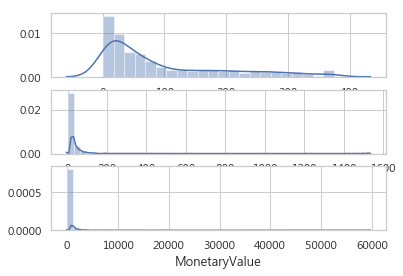

In [48]:
import seaborn as sns 
from matplotlib import pyplot as plt 
# Plot recency distribution
plt.subplot(3, 1, 1); sns.distplot(datamart['Recency'])
# Plot frequency distribution
plt.subplot(3, 1, 2); sns.distplot(datamart['Frequency'])
# Plot monetary value distribution
plt.subplot(3, 1, 3); sns.distplot(datamart['MonetaryValue'])
# Show the plot
plt.show()

In [49]:
import numpy as np
datamart_normalized = np.log(datamart)
datamart_normalized=datamart_normalized.replace(-np.inf, np.nan)
datamart_normalized=datamart_normalized.fillna(datamart_normalized.mean())
datamart_normalized.head()

,Recency,Frequency,MonetaryValue
CustomerID,,,
12747,0.693147,3.295837,6.900549
12748,0.000000,6.871091,8.805117
12749,1.386294,3.610918,6.701284
12820,1.098612,2.833213,5.591062
12822,4.262680,2.197225,4.984633


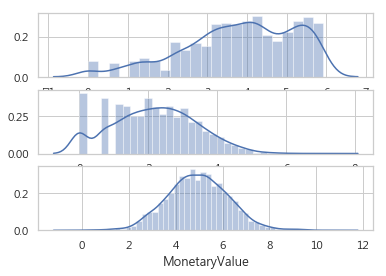

In [50]:
#先讓分配比較不會skew
plt.subplot(3, 1, 1); sns.distplot(datamart_normalized['Recency'])
# Plot frequency distribution
plt.subplot(3, 1, 2); sns.distplot(datamart_normalized['Frequency'])
# Plot monetary value distribution
plt.subplot(3, 1, 3); sns.distplot(datamart_normalized['MonetaryValue'])
# Show the plot
plt.show()

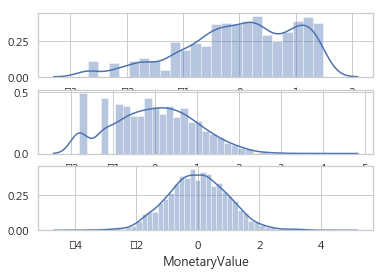

In [51]:
from sklearn.preprocessing import StandardScaler 
scaler = StandardScaler() 
scaler.fit(datamart_normalized) 
datamart_normalized = scaler.transform(datamart_normalized)
datamart_normalized = pd.DataFrame(data=datamart_normalized, index=datamart.index, columns=datamart.columns)
# Plot recency distribution
plt.subplot(3, 1, 1); sns.distplot(datamart_normalized['Recency'])

# Plot frequency distribution
plt.subplot(3, 1, 2); sns.distplot(datamart_normalized['Frequency'])

# Plot monetary value distribution
plt.subplot(3, 1, 3); sns.distplot(datamart_normalized['MonetaryValue'])

# Show the plot
plt.show()

In [52]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=2, random_state=1)
kmeans.fit(datamart_normalized)
cluster_labels = kmeans.labels_
datamart_rfm_k2 = datamart.assign(Cluster = cluster_labels)
datamart_rfm_k2.groupby(['Cluster']).agg({'Recency': 'mean','Frequency': 'mean','MonetaryValue': ['mean','count'],}).round(0)

Recency Frequency MonetaryValue      
           mean      mean          mean count
Cluster                                      
0         145.0       5.0          91.0  2023
1          33.0      36.0         722.0  1676

In [53]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=3, random_state=1)
kmeans.fit(datamart_normalized)
cluster_labels = kmeans.labels_
datamart_rfm_k3 = datamart.assign(Cluster = cluster_labels)
datamart_rfm_k3.groupby(['Cluster']).agg({'Recency': 'mean','Frequency': 'mean','MonetaryValue': ['mean','count'],}).round(0)

Recency Frequency MonetaryValue      
           mean      mean          mean count
Cluster                                      
0          14.0      53.0        1114.0   855
1          78.0      14.0         231.0  1617
2         172.0       3.0          55.0  1227

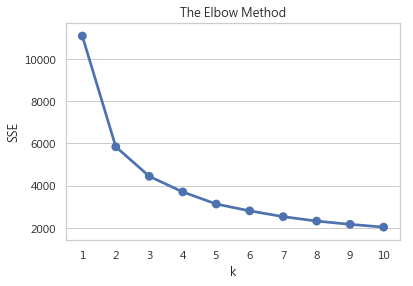

In [54]:
from sklearn.cluster import KMeans
import seaborn as sns
from matplotlib import pyplot as plt
sse = {}
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=1)
    kmeans.fit(datamart_normalized)
    sse[k] = kmeans.inertia_ # sum of squared distances to closest cluster cente
# Plot SSE for each *k*
plt.title('The Elbow Method')
plt.xlabel('k'); plt.ylabel('SSE')
sns.pointplot(x=list(sse.keys()), y=list(sse.values()))
plt.show()

In [55]:
#Look at the chart to identify where the decrease in SSE slows down and becomes somewhat marginal.
#The way to look at it is try to find the point with the largest angle which is so-called the elbow.

In [56]:
cluster_avg = datamart_rfm_k2.groupby(['Cluster']).mean()
population_avg = datamart.mean()
relative_imp = cluster_avg / population_avg - 1
relative_imp.round(2)

,Recency,Frequency,MonetaryValue
Cluster,,,
0,0.54,-0.72,-0.76
1,-0.65,0.87,0.91


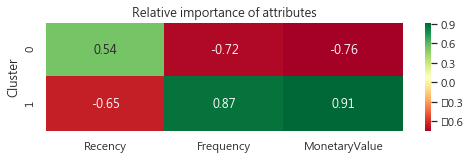

In [57]:
plt.figure(figsize=(8, 2))
plt.title('Relative importance of attributes')
sns.heatmap(data=relative_imp, annot=True, fmt='.2f'
, cmap='RdYlGn')
plt.show()